In [1]:
import numpy as np
import pandas as pd
import hist
from hist import Hist
import awkward as ak
import json
import uproot

import matplotlib.pyplot as plt
import mplhep
plt.style.use(mplhep.style.CMS)

# Samples

* [BulkGraviton](#bulk)
* [ggF](#ggf)
* [QCD](#qcd)

# BulkGraviton sample <a class="anchor" id="bulk"></a>

In [3]:
from coffea.nanoevents import NanoEventsFactory, BaseSchema

fname = "root://eoscms.cern.ch//eos/cms/store/group/ml/Tagging4ScoutingHackathon/Adelina/hbb/20epoch/massreg/pred.root"
jets = NanoEventsFactory.from_root(fname, treepath='Events', schemaclass=BaseSchema).events()

In [28]:
from coffea.nanoevents import NanoEventsFactory, ScoutingNanoAODSchema, ScoutingJMENanoAODSchema, BaseSchema
from coffea import processor, util
from collections import defaultdict

class Processor(processor.ProcessorABC):
    def __init__(self):
        pass

    def process(self, jets):
                
        dataset = jets.metadata['dataset']
        output = defaultdict()
        
        h = Hist(
            hist.axis.Regular(50, 0, 2, name="msd", label=r"$m_{SD} / target mass$"),
            hist.axis.Regular(50, 0, 2, name="reg", label=r"regressed mass / target mass"),
            hist.axis.Regular(30, 20, 260, name="target", label=r"Target mass"),
            hist.axis.Regular(30, 200, 2000, name="pt", label=r"$p_T"),
            hist.axis.StrCategory([], name="cat", label="Category", growth=True)
        )
        
        def normalise(arr):
            return ak.to_numpy(ak.fill_none(arr, np.nan))
        
        jets = jets[
            (jets.fj_pt > 200) &
            (jets.fj_pt < 2000) &
            (jets.fj_msd < 260)
        ]
        
        cat = np.zeros(len(jets.fj_pt))
        cat = ["qcd" if qcd else c for c, qcd in zip(cat, jets.sample_isQCD.to_numpy())]
        cat = ["hbb" if hbb else c for c, hbb in zip(cat, jets.label_H_bb.to_numpy())]
        cat = ["hcc" if hcc else c for c, hcc in zip(cat, jets.label_H_cc.to_numpy())]
        cat = ["hqq" if hqq else c for c, hqq in zip(cat, jets.label_H_qq.to_numpy())]
        cat = ["htautau" if htautau else c for c, htautau in zip(cat, jets.label_H_tautau.to_numpy())]

        h.fill(
            msd = normalise(jets.fj_msd/jets.target_mass),
            reg = normalise(jets.output/jets.target_mass),
            target = normalise(jets.target_mass),
            pt = normalise(jets.fj_pt),
            cat = normalise(cat)
        )
        
        output["h"] = h

        return output

    def postprocess(self, accumulator):
        pass

In [29]:
futures_run = processor.Runner(
    executor = processor.FuturesExecutor(compression=None, workers=2),
    schema=BaseSchema,
)

output = futures_run(
    {
        "pred" : [fname],
    },
    "Events",
    processor_instance=Processor()
)

util.save(output, "outfiles/2022/tagger/massreg.coffea")

Output()

In [201]:
output = util.load("outfiles/2022/tagger/massreg.coffea")

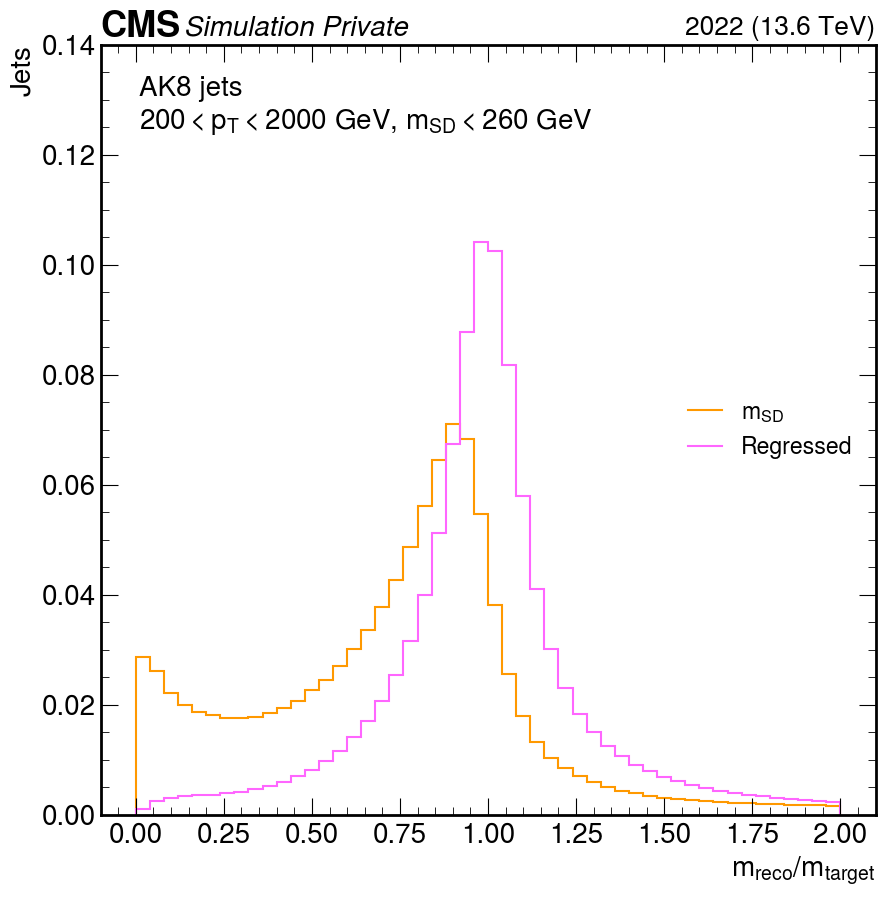

In [202]:
fig, ax = plt.subplots(figsize=(10,10))

colours = {
    "black" : "black",
    "hbb" : "#FF66FF",
    "qcd" : "#FF9900",
    "hcc" : "deepskyblue",
    "hqq" : "limegreen",
}

h = output["h"]

h1 = h.project("msd")
n = h1.sum()
h1 = h1 / n
    
mplhep.histplot(h1, ax=ax, label=r"$m_{SD}$", color=colours["qcd"])

h1 = h.project("reg")
n = h1.sum()
h1 = h1 / n
    
mplhep.histplot(h1, ax=ax, label=r"Regressed", color=colours["hbb"])
    
ax.legend(loc="center right")
ax.set_xlabel(r"$m_{reco} / m_{target}$")
ax.set_ylabel("Jets")
ax.set_ylim(0, 0.14)

label = mplhep.cms.label(ax=ax, data=False, year="2022", com=13.6, label="Private")

coffee = plt.text(0.05, 0.88, "\nAK8 jets\n" + r"$200 < p_T < 2000$ GeV, $m_{SD} < 260$ GeV",
                  fontsize=20,
                  horizontalalignment='left',
                  verticalalignment='bottom',
                  transform=ax.transAxes,
                 )


# fig.savefig("Disc.pdf", bbox_inches='tight', pad_inches=0.1)

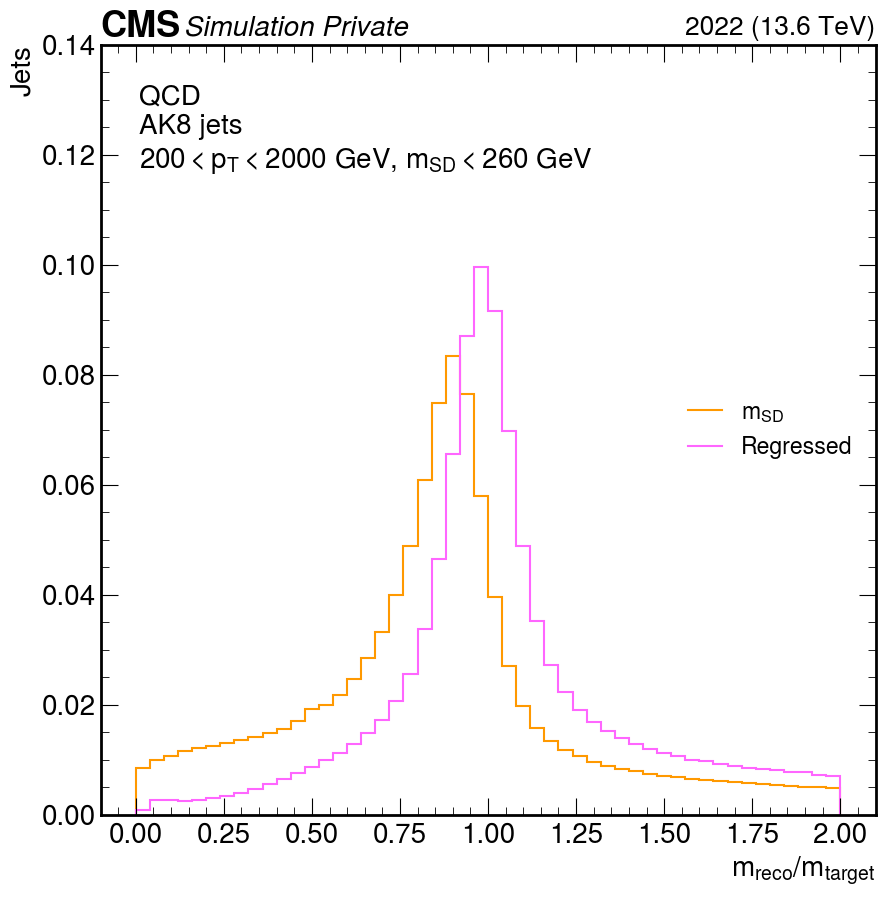

In [203]:
fig, ax = plt.subplots(figsize=(10,10))

colours = {
    "black" : "black",
    "hbb" : "#FF66FF",
    "qcd" : "#FF9900",
    "hcc" : "deepskyblue",
    "hqq" : "limegreen",
}

samples = {
    "qcd" : "QCD",
    "hbb" : r"$H\rightarrow b\bar{b}$",
    "hcc" : r"$H\rightarrow c\bar{c}$",
    "hqq" : r"$H\rightarrow q\bar{q}$",
    "htautau" : r"$H\rightarrow \tau\bar{\tau}$",
}
sample = "qcd"

h = output["h"]

h1 = h.project("msd", "cat")[:, hist.loc(sample)]
n = h1.sum()
h1 = h1 / n
    
mplhep.histplot(h1, ax=ax, label=r"$m_{SD}$", color=colours["qcd"])

h1 = h.project("reg", "cat")[:, hist.loc(sample)]
n = h1.sum()
h1 = h1 / n
    
mplhep.histplot(h1, ax=ax, label=r"Regressed", color=colours["hbb"])
    
ax.legend(loc="center right")
ax.set_xlabel(r"$m_{reco} / m_{target}$")
ax.set_ylabel("Jets")
ax.set_ylim(0, 0.14)

label = mplhep.cms.label(ax=ax, data=False, year="2022", com=13.6, label="Private")

coffee = plt.text(0.05, 0.83, samples[sample] + "\nAK8 jets\n" + r"$200 < p_T < 2000$ GeV, $m_{SD} < 260$ GeV",
                  fontsize=20,
                  horizontalalignment='left',
                  verticalalignment='bottom',
                  transform=ax.transAxes,
                 )

# fig.savefig("Disc.pdf", bbox_inches='tight', pad_inches=0.1)

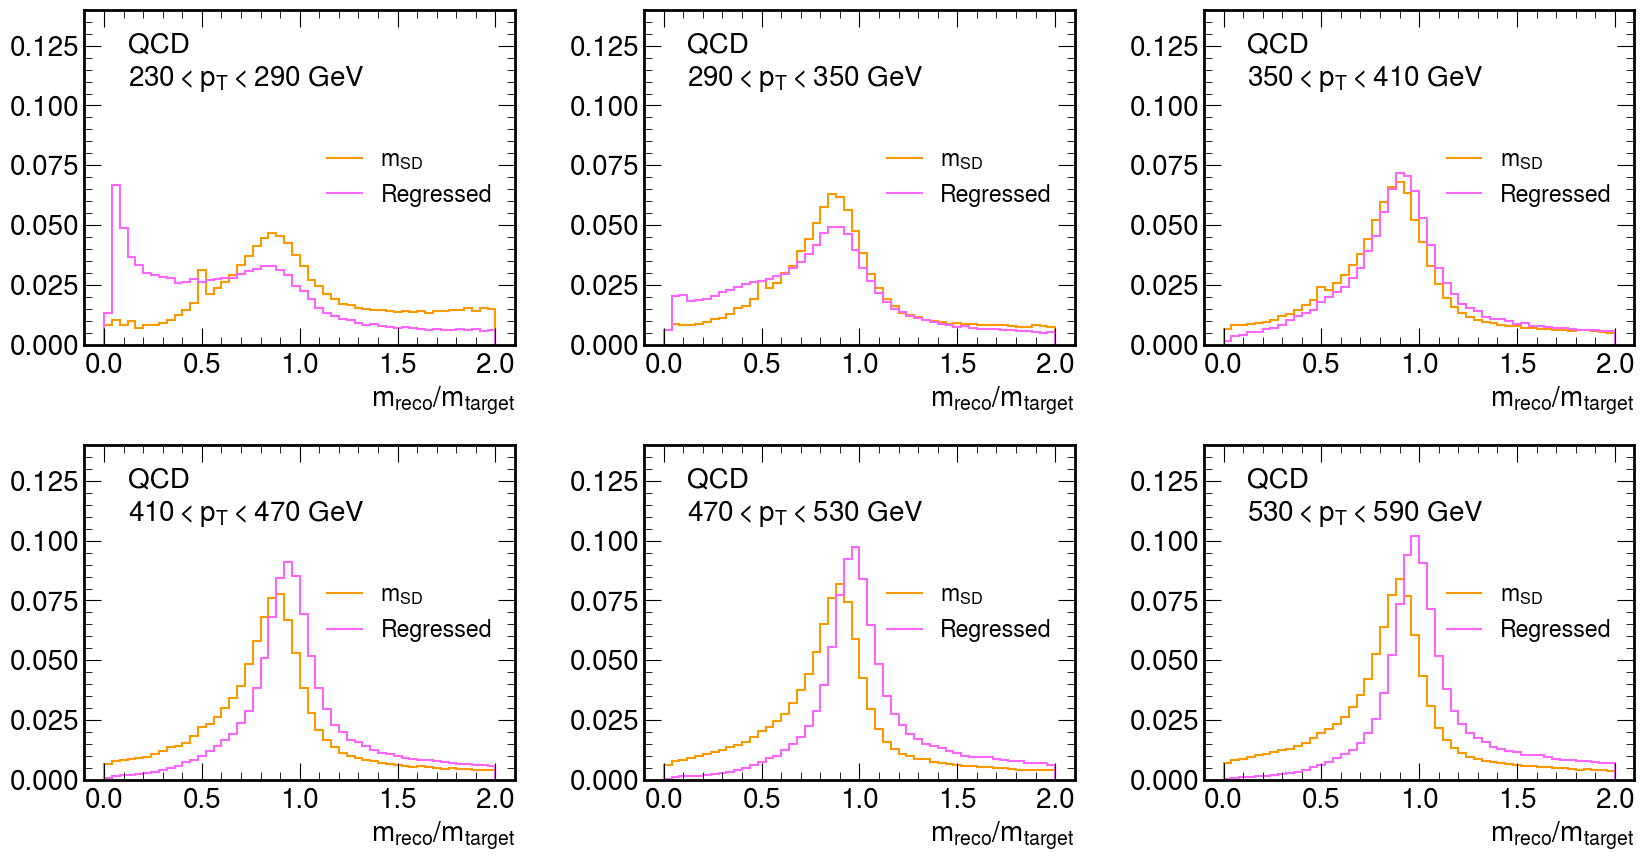

In [103]:
plt.rcParams.update({
    'font.size': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
})

colours = {
    "black" : "black",
    "hbb" : "#FF66FF",
    "qcd" : "#FF9900",
    "hcc" : "deepskyblue",
    "hqq" : "limegreen",
}

samples = {
    "qcd" : "QCD",
    "hbb" : r"$H\rightarrow b\bar{b}$",
    "hcc" : r"$H\rightarrow c\bar{c}$",
    "hqq" : r"$H\rightarrow q\bar{q}$",
    "htautau" : r"$H\rightarrow \tau\bar{\tau}$",
}
sample = "qcd"

h = output["h"]
edges = h.project("pt").axes[0].centers

fig, axs = plt.subplots(2, 3, figsize=(20, 10))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
i_row, i_column = 0, 0

for i, _ in enumerate(edges):
    
    if i > 5:
        break  
        
    ax = axs[i_row, i_column]
    
    h1 = h.project("msd", "pt", "cat")[:, i:i+1:sum, hist.loc(sample)]
    n = h1.sum()
    h1 = h1 / n

    mplhep.histplot(h1, ax=ax, label=r"$m_{SD}$", color=colours["qcd"])

    h1 = h.project("reg", "pt", "cat")[:, i:i+1:sum, hist.loc(sample)]
    n = h1.sum()
    h1 = h1 / n

    mplhep.histplot(h1, ax=ax, label=r"Regressed", color=colours["hbb"])

    ax.legend(loc="center right")
    ax.set_xlabel(r"$m_{reco} / m_{target}$")
    ax.set_ylim(0, 0.14)

    coffee = plt.text(0.1, 0.75, f"{samples[sample]}\n{edges[i]:.0f}" + r"$ < p_T <$" + f"{edges[i+1]:.0f} GeV",
                      fontsize=20,
                      horizontalalignment='left',
                      verticalalignment='bottom',
                      transform=ax.transAxes,
                     )
    
    i_column += 1
    if i_column > 2:
        i_row +=1
        i_column = 0

    # fig.savefig("Disc.pdf", bbox_inches='tight', pad_inches=0.1)

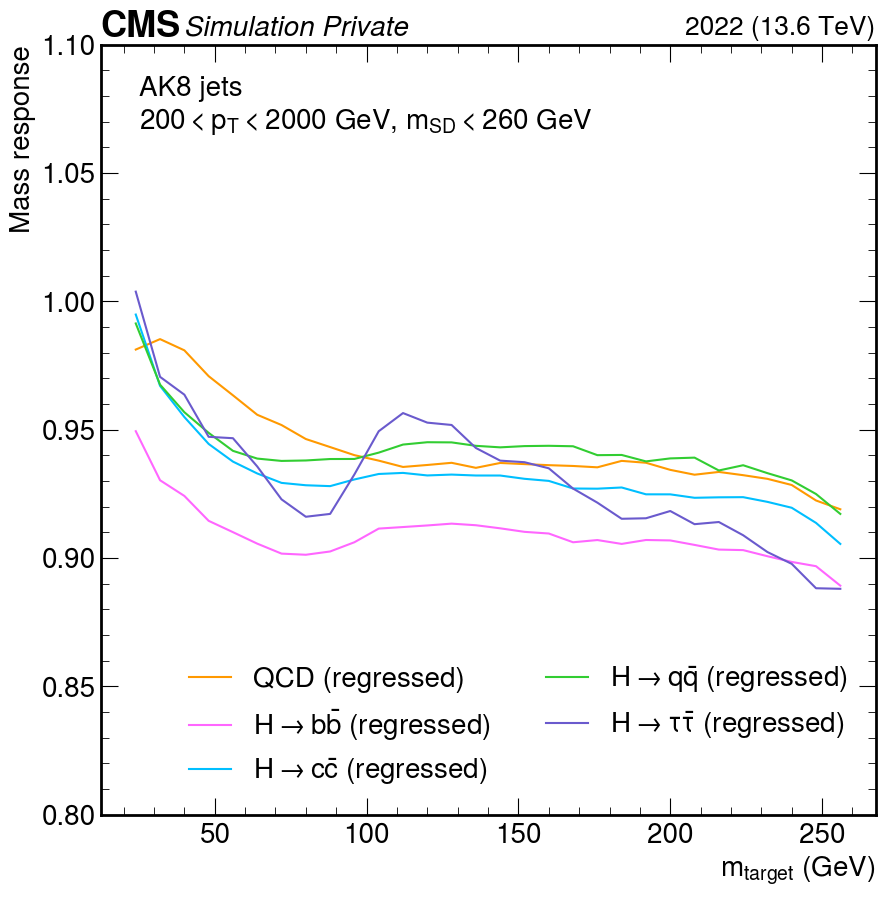

In [206]:
fig, ax = plt.subplots(figsize=(10,10))

from test.jer import (
    mean,
)

colours = {
    "black" : "black",
    "hbb" : "#FF66FF",
    "qcd" : "#FF9900",
    "hcc" : "deepskyblue",
    "hqq" : "limegreen",
    "htautau" : "slateblue",
}

samples = {
    "qcd" : "QCD",
    "hbb" : r"$H\rightarrow b\bar{b}$",
    "hcc" : r"$H\rightarrow c\bar{c}$",
    "hqq" : r"$H\rightarrow q\bar{q}$",
    "htautau" : r"$H\rightarrow \tau\bar{\tau}$",
}

h = output["h"]
centers = h.project("target").axes[0].centers

for mass in ["reg"]:
    for sample in samples.keys():
    
        centers2 = []
        response = []
        for i, center in enumerate(centers):

            h1 = h.project(mass, "cat", "target")[:, hist.loc(sample), i]
            if h1.sum() < 2:
                continue
            response.append(mean(h1))
            centers2.append(center)

        ax.errorbar(centers2, response, 
                    label=samples[sample] + (r" ($m_{SD})$" if "msd" in mass else " (regressed)"),
                    color=colours[sample], linestyle="--" if "msd" in mass else "-")

ax.legend(loc="lower right", fontsize=20, ncol=2) #bbox_to_anchor=(1, 0.8),
ax.set_xlabel(r"$m_{target}$ (GeV)")
ax.set_ylabel("Mass response")
ax.set_ylim(0.8, 1.1)

label = mplhep.cms.label(ax=ax, data=False, year="2022", com=13.6, label="Private")

coffee = plt.text(0.05, 0.88, "\nAK8 jets\n" + r"$200 < p_T < 2000$ GeV, $m_{SD} < 260$ GeV",
                  fontsize=20,
                  horizontalalignment='left',
                  verticalalignment='bottom',
                  transform=ax.transAxes,
                 )

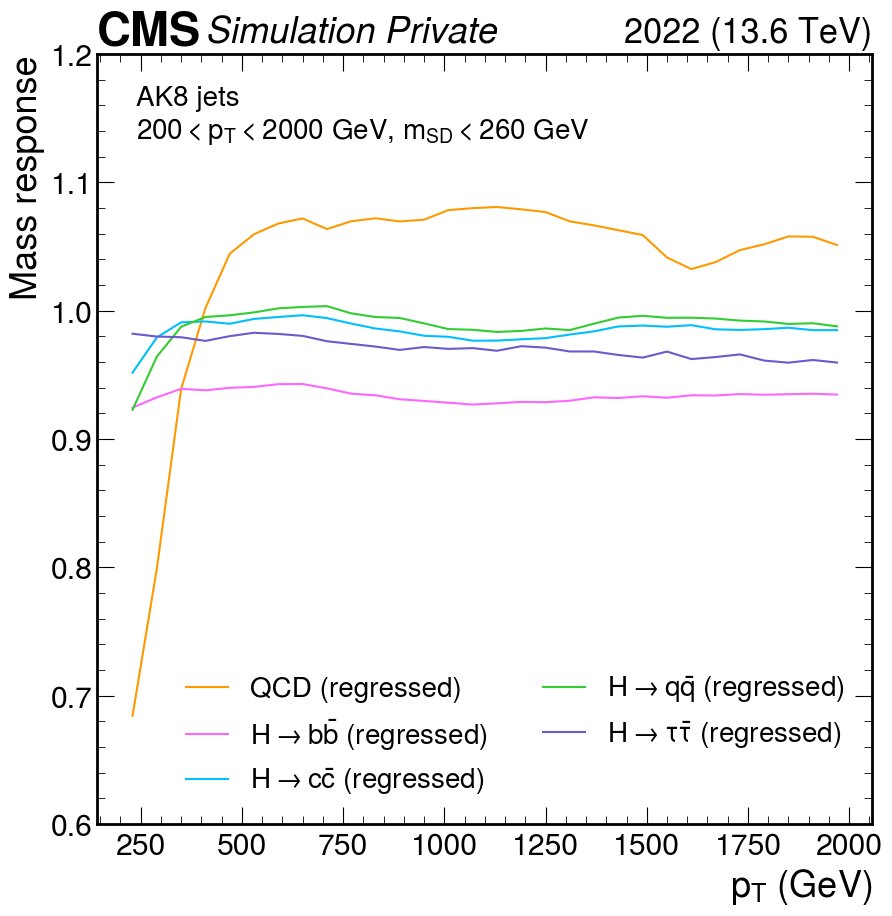

In [54]:
fig, ax = plt.subplots(figsize=(10,10))

def most_prob(h):
    i = np.argmax(h.values())
    return h.axes[0].centers[i]

colours = {
    "black" : "black",
    "hbb" : "#FF66FF",
    "qcd" : "#FF9900",
    "hcc" : "deepskyblue",
    "hqq" : "limegreen",
    "htautau" : "slateblue",
}

samples = {
    "qcd" : "QCD",
    "hbb" : r"$H\rightarrow b\bar{b}$",
    "hcc" : r"$H\rightarrow c\bar{c}$",
    "hqq" : r"$H\rightarrow q\bar{q}$",
    "htautau" : r"$H\rightarrow \tau\bar{\tau}$",
}

h = output["h"]
centers = h.project("pt").axes[0].centers

for mass in ["reg"]:
    for sample in samples.keys():
    
        centers2 = []
        response = []
        for i, center in enumerate(centers):

            h1 = h.project(mass, "cat", "pt")[:, hist.loc(sample), i]
            if h1.sum() < 2:
                continue
            response.append(most_prob(h1))
            centers2.append(center)

        ax.errorbar(centers2, response, 
                    label=samples[sample] + (r" ($m_{SD})$" if "msd" in mass else " (regressed)"),
                    color=colours[sample], linestyle="--" if "msd" in mass else "-")

ax.legend(loc="lower right", fontsize=20, ncol=2) #bbox_to_anchor=(1, 0.8),
ax.set_xlabel(r"$p_T$ (GeV)")
ax.set_ylabel("Mass response")
ax.set_ylim(0.6, 1.2)

label = mplhep.cms.label(ax=ax, data=False, year="2022", com=13.6, label="Private")

coffee = plt.text(0.05, 0.88, "\nAK8 jets\n" + r"$200 < p_T < 2000$ GeV, $m_{SD} < 260$ GeV",
                  fontsize=20,
                  horizontalalignment='left',
                  verticalalignment='bottom',
                  transform=ax.transAxes,
                 )

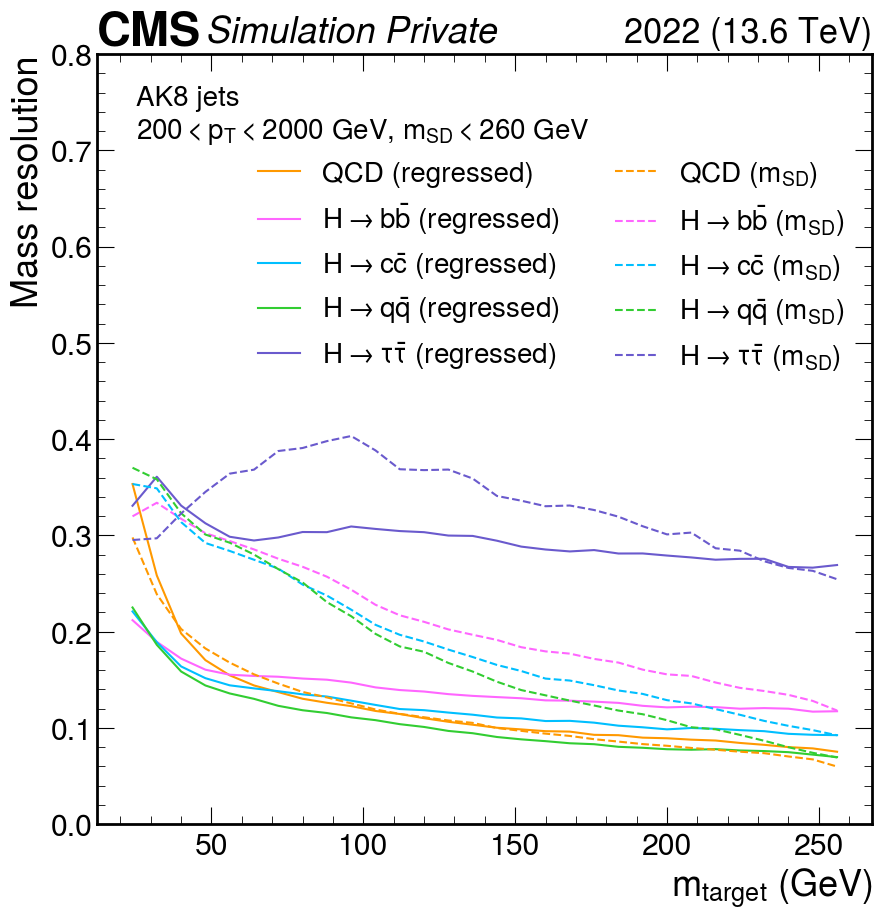

In [58]:
fig, ax = plt.subplots(figsize=(10,10))

from test.jer import (
    median,
    confidence,
)

colours = {
    "black" : "black",
    "hbb" : "#FF66FF",
    "qcd" : "#FF9900",
    "hcc" : "deepskyblue",
    "hqq" : "limegreen",
    "htautau" : "slateblue",
}

samples = {
    "qcd" : "QCD",
    "hbb" : r"$H\rightarrow b\bar{b}$",
    "hcc" : r"$H\rightarrow c\bar{c}$",
    "hqq" : r"$H\rightarrow q\bar{q}$",
    "htautau" : r"$H\rightarrow \tau\bar{\tau}$",
}

h = output["h"]
centers = h.project("target").axes[0].centers

for mass in ["reg", "msd"]:
    for sample in samples.keys():
    
        centers2 = []
        resolution = []
        for i, center in enumerate(centers):

            h1 = h.project(mass, "cat", "target")[:, hist.loc(sample), i]
            if h1.sum() < 2:
                continue
            resolution.append(confidence(h1))
            centers2.append(center)

        ax.errorbar(centers2, resolution, 
                    label=samples[sample] + (r" ($m_{SD})$" if "msd" in mass else " (regressed)"),
                    color=colours[sample], linestyle="--" if "msd" in mass else "-")

ax.legend(ncol=2, bbox_to_anchor=(1, 0.9), fontsize=20)
ax.set_xlabel(r"$m_{target}$ (GeV)")
ax.set_ylabel("Mass resolution")
ax.set_ylim(0, 0.8)

label = mplhep.cms.label(ax=ax, data=False, year="2022", com=13.6, label="Private")

coffee = plt.text(0.05, 0.88, "\nAK8 jets\n" + r"$200 < p_T < 2000$ GeV, $m_{SD} < 260$ GeV",
                  fontsize=20,
                  horizontalalignment='left',
                  verticalalignment='bottom',
                  transform=ax.transAxes,
                 )

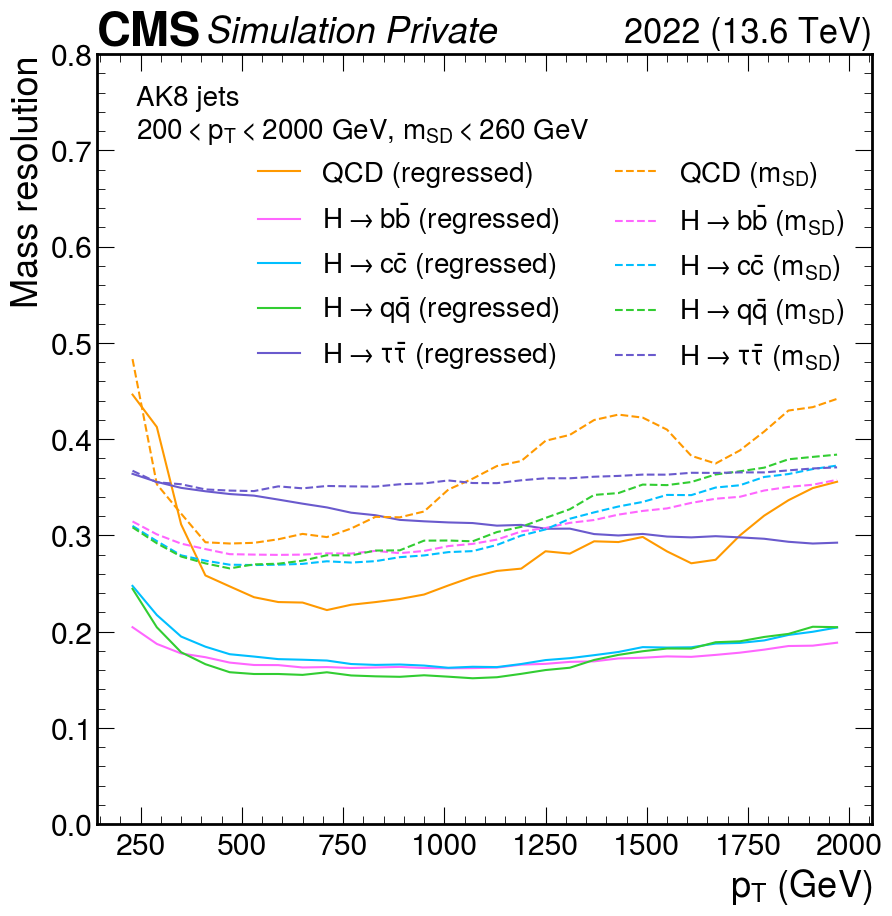

In [59]:
fig, ax = plt.subplots(figsize=(10,10))

from test.jer import (
    median,
    confidence,
)

colours = {
    "black" : "black",
    "hbb" : "#FF66FF",
    "qcd" : "#FF9900",
    "hcc" : "deepskyblue",
    "hqq" : "limegreen",
    "htautau" : "slateblue",
}

samples = {
    "qcd" : "QCD",
    "hbb" : r"$H\rightarrow b\bar{b}$",
    "hcc" : r"$H\rightarrow c\bar{c}$",
    "hqq" : r"$H\rightarrow q\bar{q}$",
    "htautau" : r"$H\rightarrow \tau\bar{\tau}$",
}

h = output["h"]
centers = h.project("pt").axes[0].centers

for mass in ["reg", "msd"]:
    for sample in samples.keys():
    
        centers2 = []
        resolution = []
        for i, center in enumerate(centers):

            h1 = h.project(mass, "cat", "pt")[:, hist.loc(sample), i]
            if h1.sum() < 2:
                continue
            resolution.append(confidence(h1))
            centers2.append(center)

        ax.errorbar(centers2, resolution, 
                    label=samples[sample] + (r" ($m_{SD})$" if "msd" in mass else " (regressed)"),
                    color=colours[sample], linestyle="--" if "msd" in mass else "-")

ax.legend(ncol=2, bbox_to_anchor=(1, 0.9), fontsize=20)
ax.set_xlabel(r"$p_T$ (GeV)")
ax.set_ylabel("Mass resolution")
ax.set_ylim(0, 0.8)

label = mplhep.cms.label(ax=ax, data=False, year="2022", com=13.6, label="Private")

coffee = plt.text(0.05, 0.88, "\nAK8 jets\n" + r"$200 < p_T < 2000$ GeV, $m_{SD} < 260$ GeV",
                  fontsize=20,
                  horizontalalignment='left',
                  verticalalignment='bottom',
                  transform=ax.transAxes,
                 )

# ggF sample <a class="anchor" id="ggf"></a>

In [175]:
from coffea.nanoevents import NanoEventsFactory, ScoutingNanoAODSchema, ScoutingJMENanoAODSchema, BaseSchema
from coffea import processor, util
from collections import defaultdict

class Processor(processor.ProcessorABC):
    def __init__(self):
        pass

    def process(self, events):
        
        dataset = events.metadata['dataset']
        output = defaultdict()
        output["nevents"] = len(events)
        
        h = Hist(
#             hist.axis.Regular(30, 0, 200, name="msd", label=r"$m_{SD}$"),
#             hist.axis.Regular(30, 0, 200, name="reg", label=r"Regressed mass"),
            hist.axis.Regular(50, 0, 2, name="rat_msd", label=r"$m_{SD} / target mass$"),
            hist.axis.Regular(50, 0, 2, name="rat_reg", label=r"regressed mass / target mass"),
            hist.axis.Regular(50, 200, 1200, name="pt", label=r"$p_T"),
            hist.axis.Boolean(name="match"),
        )
        
        def normalise(arr):
            return ak.to_numpy(ak.fill_none(arr, np.nan))

        def hbb_disc(sig, bkg):
            return ak.where((sig + bkg == 0), 0, sig / (sig + bkg))
        
        fatjets = events.ScoutingFatJet
        fatjets = fatjets[
            (fatjets.pt > 200) &
            (fatjets.pt < 2000) &
            (fatjets.msoftdrop < 260)
        ]
        fatjet = ak.firsts(fatjets)

        # get Higgs
        H = events.GenPart[
            (abs(events.GenPart.pdgId) == 25)
            & (events.GenPart.hasFlags(['fromHardProcess', 'isLastCopy']))
        ]

        # get b quarks
        b_H = ak.flatten(H.children)

        b_H_dr = fatjet.delta_r(b_H)
        index_descend_b_H = ak.argsort(b_H_dr, axis=1, ascending=False)
        b_H_dr_descend = b_H_dr[index_descend_b_H]

        # is fatjet matched to b quarks?
        is_fatjet_b_H = ak.firsts(b_H_dr_descend, axis=1) < 0.8
        
        disc = hbb_disc(
            fatjet.particleNet_prob_Hbb,
            fatjet.particleNet_prob_QCD
        )

        h.fill(
#             msd = normalise(fatjet.msoftdrop),
#             reg = normalise(fatjet.particleNet_mass),
            rat_msd = normalise(fatjet.msoftdrop / ak.firsts(H.mass)),
            rat_reg = normalise(fatjet.particleNet_mass / ak.firsts(H.mass)),
            pt = normalise(fatjet.pt),
            match = normalise(is_fatjet_b_H),
        )
        
        output["h"] = h

        return output

    def postprocess(self, accumulator):
        pass

In [176]:
fileset = {}
with open("inputfiles/2022/GluGluHto2B_v3.json") as fin:
    fileset = json.load(fin)

futures_run = processor.Runner(
    executor = processor.FuturesExecutor(compression=None, workers=2),
    schema=ScoutingNanoAODSchema,
)

output = futures_run(
    fileset,
    "Events",
    processor_instance=Processor()
)

util.save(output, "outfiles/2022/tagger/massreg_GluGluHto2B.coffea")

Output()

/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(
/opt/conda/lib/python3.8/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(


/tmp/ipykernel_30/34876043.py:22: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 2)


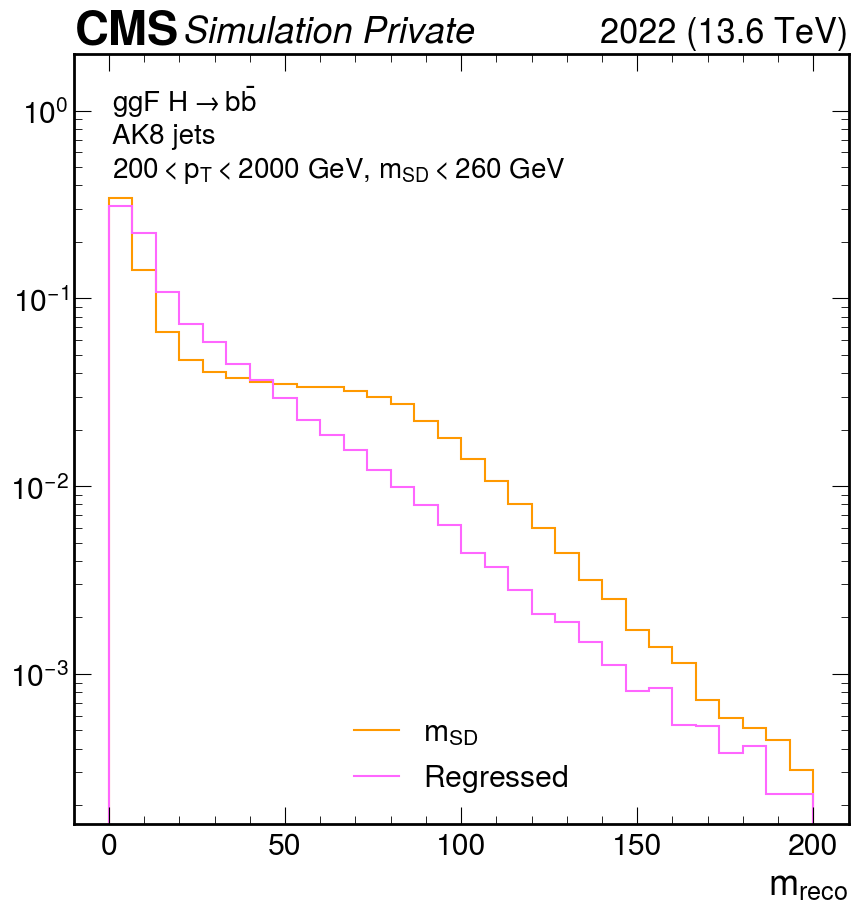

In [129]:
plt.style.use(mplhep.style.CMS)

fig, ax = plt.subplots(figsize=(10,10))

h = output["h"]

h1 = h.project("msd", "match")[:, hist.loc(0)]
n = h1.sum()
h1 = h1 / n
    
mplhep.histplot(h1, ax=ax, label=r"$m_{SD}$", color=colours["qcd"])

h1 = h.project("reg", "match")[:, hist.loc(0)]
n = h1.sum()
h1 = h1 / n
    
mplhep.histplot(h1, ax=ax, label=r"$Regressed$", color=colours["hbb"])
    
ax.set_yscale('log')
ax.set_xlabel(r"$m_{reco}$")
ax.legend(loc="lower center")
ax.set_ylim(0, 2)
              
label = mplhep.cms.label(ax=ax, data=False, year="2022", com=13.6, label="Private")

coffee = plt.text(0.05, 0.83, r"ggF $H\rightarrow b\bar{b}$" + "\nAK8 jets\n" + r"$200 < p_T < 2000$ GeV, $m_{SD} < 260$ GeV",
                  fontsize=20,
                  horizontalalignment='left',
                  verticalalignment='bottom',
                  transform=ax.transAxes,
                 )
              
# fig.savefig("Disc.pdf", bbox_inches='tight', pad_inches=0.1)

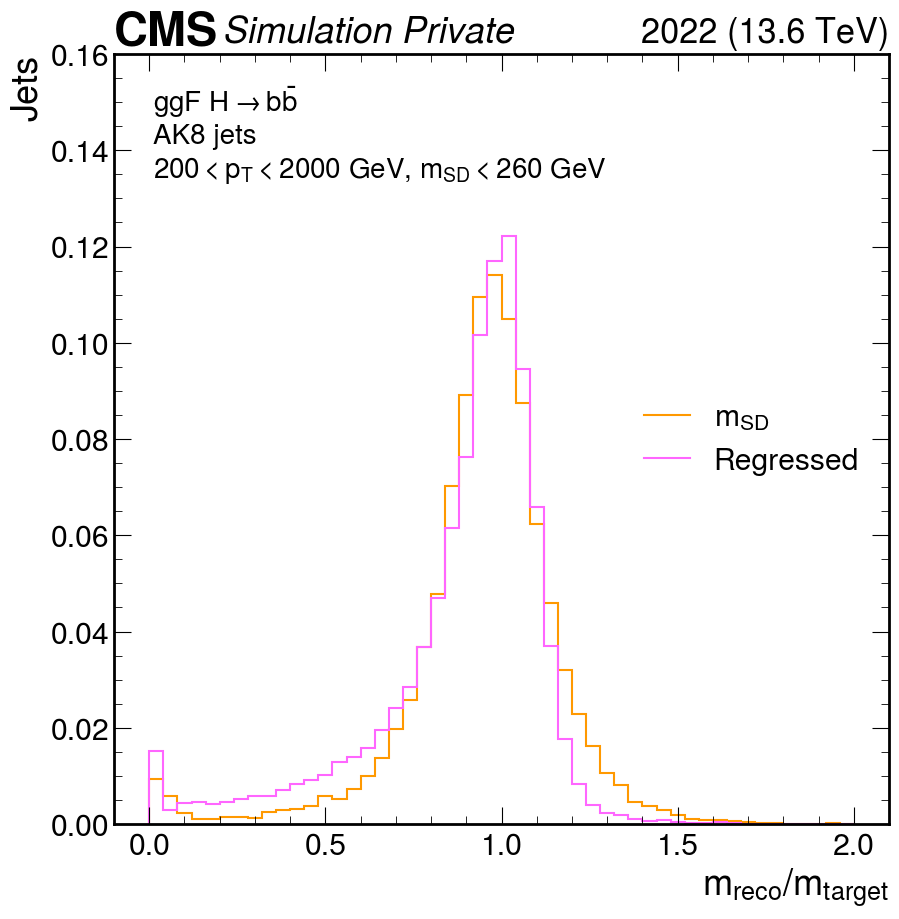

In [136]:
fig, ax = plt.subplots(figsize=(10,10))

colours = {
    "hbb" : "#FF66FF",
    "qcd" : "#FF9900",
}

h = output["h"]

h1 = h.project("rat_msd", "match")[:, hist.loc(1)]
n = h1.sum()
h1 = h1 / n
    
mplhep.histplot(h1, ax=ax, label=r"$m_{SD}$", color=colours["qcd"])

h1 = h.project("rat_reg", "match")[:, hist.loc(1)]
n = h1.sum()
h1 = h1 / n
    
mplhep.histplot(h1, ax=ax, label=r"Regressed", color=colours["hbb"])
    
ax.legend(loc="center right")
ax.set_xlabel(r"$m_{reco} / m_{target}$")
ax.set_ylabel("Jets")
ax.set_ylim(0, 0.16)

label = mplhep.cms.label(ax=ax, data=False, year="2022", com=13.6, label="Private")

coffee = plt.text(0.05, 0.83, r"ggF $H\rightarrow b\bar{b}$" + "\nAK8 jets\n" + r"$200 < p_T < 2000$ GeV, $m_{SD} < 260$ GeV",
                  fontsize=20,
                  horizontalalignment='left',
                  verticalalignment='bottom',
                  transform=ax.transAxes,
                 )


# fig.savefig("Disc.pdf", bbox_inches='tight', pad_inches=0.1)

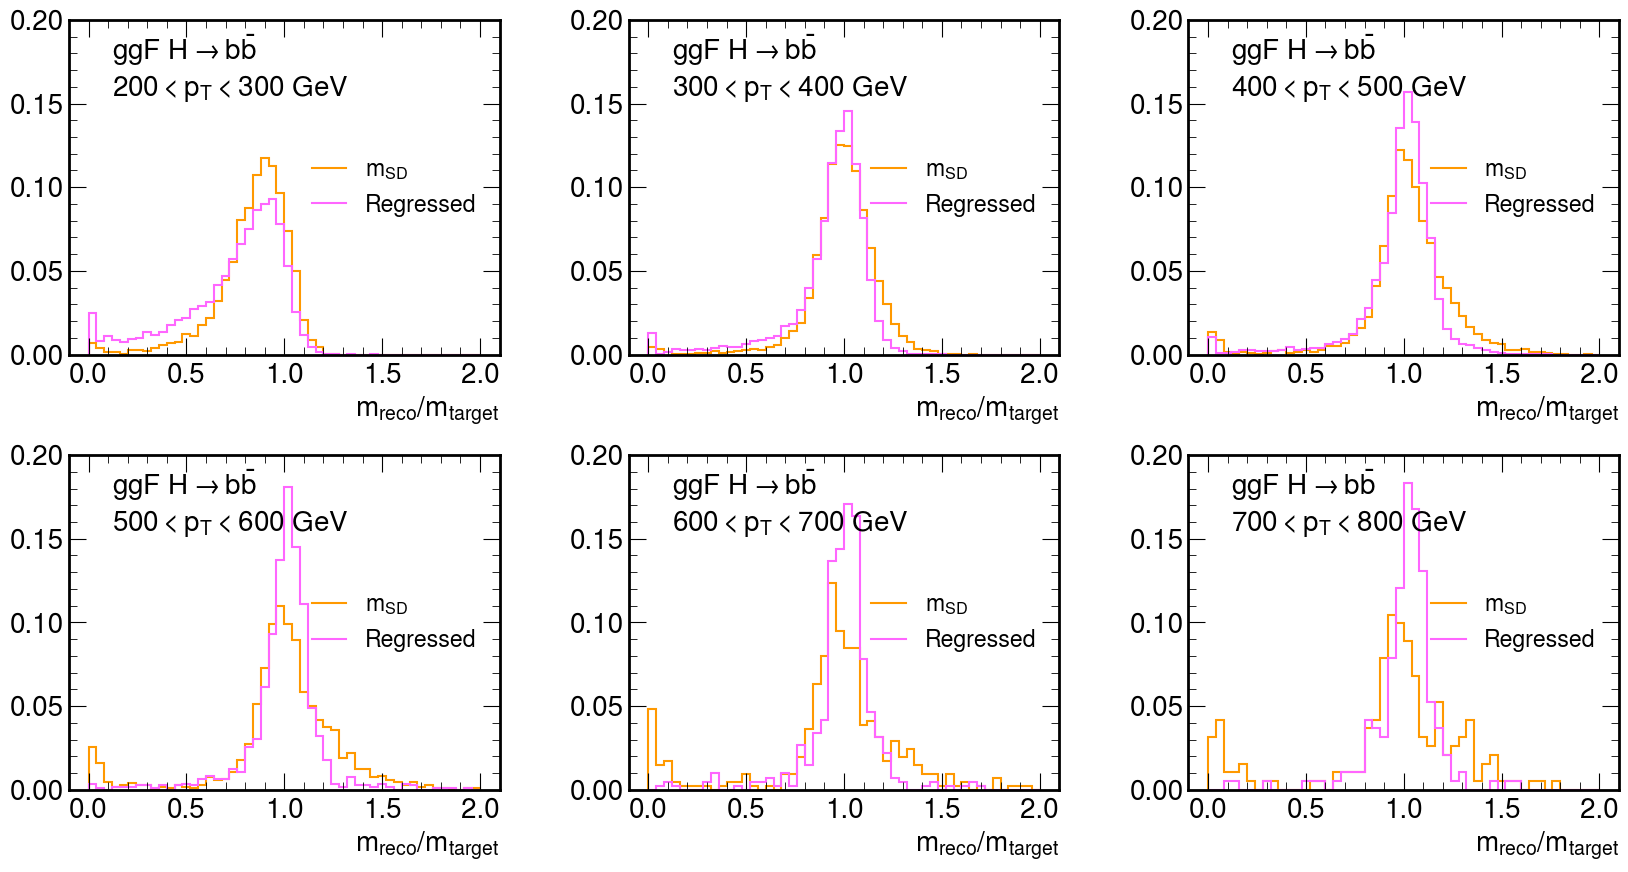

In [184]:
plt.rcParams.update({
    'font.size': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
})

colours = {
    "hbb" : "#FF66FF",
    "qcd" : "#FF9900",
}

h = output["h"]
edges = h.project("pt")[hist.rebin(5)].axes[0].edges

fig, axs = plt.subplots(2, 3, figsize=(20, 10))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
i_row, i_column = 0, 0

for i, _ in enumerate(edges):
    
    if i > 5:
        break  
        
    ax = axs[i_row, i_column]
    
    h1 = h.project("rat_msd", "pt", "match")[:, hist.rebin(5), :][:, i:i+1:sum, hist.loc(1)]
    n = h1.sum()
    h1 = h1 / n

    mplhep.histplot(h1, ax=ax, label=r"$m_{SD}$", color=colours["qcd"])

    h1 = h.project("rat_reg", "pt", "match")[:, hist.rebin(5), :][:, i:i+1:sum, hist.loc(1)]
    n = h1.sum()
    h1 = h1 / n

    mplhep.histplot(h1, ax=ax, label=r"Regressed", color=colours["hbb"])

    ax.legend(loc="center right")
    ax.set_xlabel(r"$m_{reco} / m_{target}$")
    ax.set_ylim(0, 0.2)

    coffee = plt.text(0.1, 0.75, r"ggF $H\rightarrow b\bar{b}$" + f"\n{edges[i]:.0f}" + r"$ < p_T <$" + f"{edges[i+1]:.0f} GeV",
                      fontsize=20,
                      horizontalalignment='left',
                      verticalalignment='bottom',
                      transform=ax.transAxes,
                     )
    
    i_column += 1
    if i_column > 2:
        i_row +=1
        i_column = 0

    # fig.savefig("Disc.pdf", bbox_inches='tight', pad_inches=0.1)

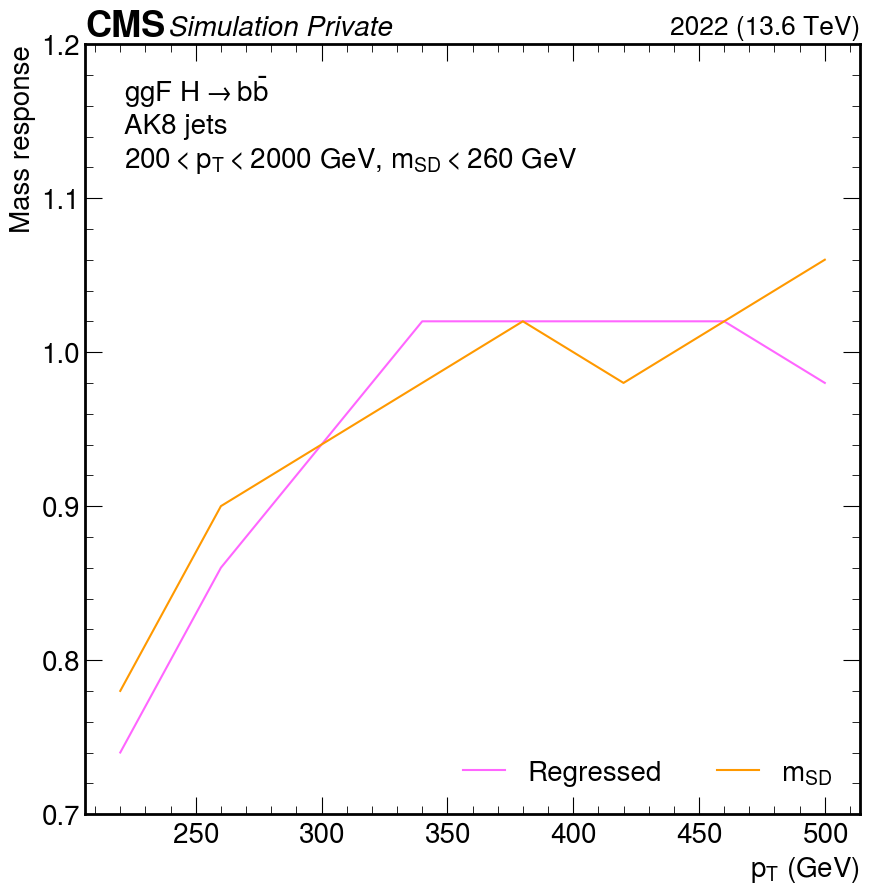

In [190]:
fig, ax = plt.subplots(figsize=(10,10))

def most_prob(h):
    i = np.argmax(h.values())
    return h.axes[0].centers[i]

colours = {
    "hbb" : "#FF66FF",
    "qcd" : "#FF9900",
}

h = output["h"]
centers = h.project("pt")[hist.rebin(2)].axes[0].centers

for mass in ["rat_reg", "rat_msd"]:
    
        centers2 = []
        response = []
        for i, center in enumerate(centers):
            
            if center > 500:
                break

            h1 = h.project(mass, "pt", "match")[:, hist.rebin(2), :][:, i, hist.loc(1)]
            if h1.sum() < 2:
                continue
            response.append(most_prob(h1))
            centers2.append(center)

        ax.errorbar(centers2, response, 
                    label=r"$m_{SD}$" if "msd" in mass else "Regressed",
                    color=colours["qcd"] if "msd" in mass else colours["hbb"])

ax.legend(loc="lower right", fontsize=20, ncol=2) #bbox_to_anchor=(1, 0.8),
ax.set_xlabel(r"$p_T$ (GeV)")
ax.set_ylabel("Mass response")
ax.set_ylim(0.7, 1.2)

label = mplhep.cms.label(ax=ax, data=False, year="2022", com=13.6, label="Private")

coffee = plt.text(0.05, 0.83, r"ggF $H\rightarrow b\bar{b}$" + "\nAK8 jets\n" + r"$200 < p_T < 2000$ GeV, $m_{SD} < 260$ GeV",
                  fontsize=20,
                  horizontalalignment='left',
                  verticalalignment='bottom',
                  transform=ax.transAxes,
                 )

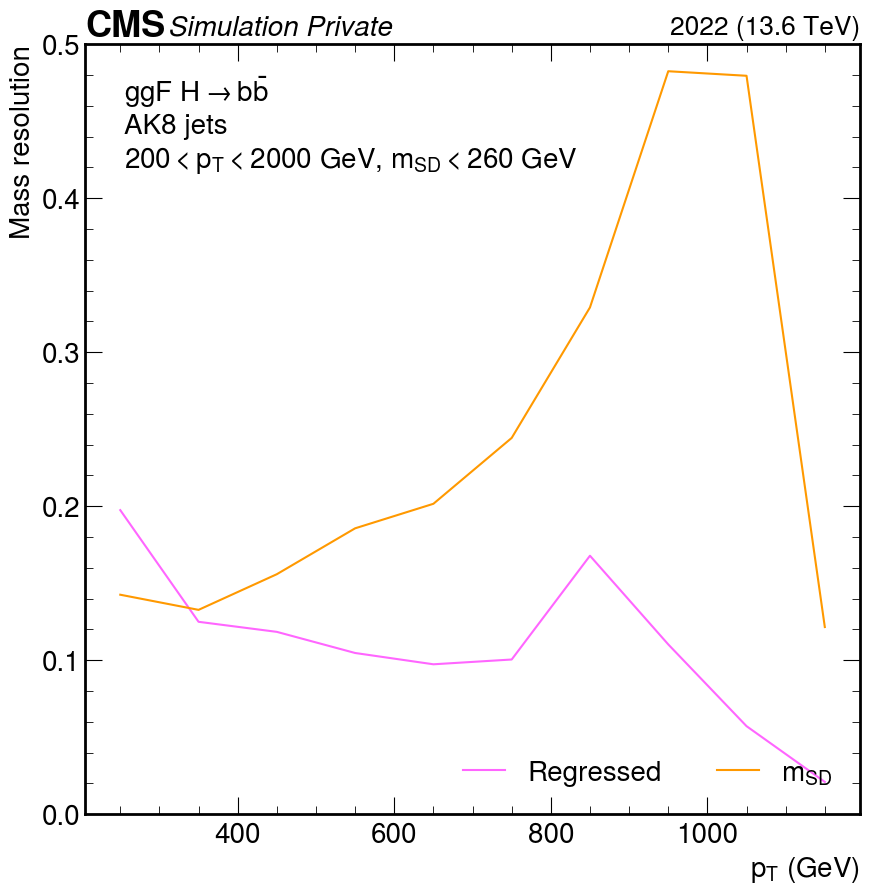

In [200]:
fig, ax = plt.subplots(figsize=(10,10))

from test.jer import (
    confidence,
)

colours = {
    "hbb" : "#FF66FF",
    "qcd" : "#FF9900",
}

h = output["h"]
centers = h.project("pt")[hist.rebin(5)].axes[0].centers

for mass in ["rat_reg", "rat_msd"]:
    
        centers2 = []
        resolution = []
        for i, center in enumerate(centers):
            
#             if center > 500:
#                 break

            h1 = h.project(mass, "pt", "match")[:, hist.rebin(5), :][:, i, hist.loc(1)]
            if h1.sum() < 2:
                continue
            resolution.append(confidence(h1))
            centers2.append(center)

        ax.errorbar(centers2, resolution, 
                    label=r"$m_{SD}$" if "msd" in mass else "Regressed",
                    color=colours["qcd"] if "msd" in mass else colours["hbb"])

ax.legend(loc="lower right", fontsize=20, ncol=2) #bbox_to_anchor=(1, 0.8),
ax.set_xlabel(r"$p_T$ (GeV)")
ax.set_ylabel("Mass resolution")
ax.set_ylim(0, 0.5)

label = mplhep.cms.label(ax=ax, data=False, year="2022", com=13.6, label="Private")

coffee = plt.text(0.05, 0.83, r"ggF $H\rightarrow b\bar{b}$" + "\nAK8 jets\n" + r"$200 < p_T < 2000$ GeV, $m_{SD} < 260$ GeV",
                  fontsize=20,
                  horizontalalignment='left',
                  verticalalignment='bottom',
                  transform=ax.transAxes,
                 )

# QCD sample <a class="anchor" id="qcd"></a>

In [207]:
from coffea.nanoevents import NanoEventsFactory, ScoutingNanoAODSchema, ScoutingJMENanoAODSchema
from coffea import processor, util
from collections import defaultdict

from processors.helper import (
    add_pileup_weight,
)

class Processor(processor.ProcessorABC):
    def __init__(self):
        pass

    def process(self, events):
        
        dataset = events.metadata['dataset']
        output = defaultdict()
        
        h = Hist(
            hist.axis.Regular(30, 0, 200, name="msd", label=r"$m_{SD}$"),
            hist.axis.Regular(30, 0, 200, name="reg", label=r"Regressed mass"),
            hist.axis.Regular(50, 200, 1200, name="pt", label=r"$p_T"),
        )
        
        def normalise(arr):
            return ak.to_numpy(ak.fill_none(arr, np.nan))

        def hbb_disc(sig, bkg):
            return ak.where((sig + bkg == 0), 0, sig / (sig + bkg))
        
        events = events[
            (events.Pileup.nPU < 100)
        ]
        
        output["nevents"] = len(events)
        
        add_pileup_weight(events)
        
        fatjets = events.ScoutingFatJet
        fatjets['weight_pileup'] = ak.broadcast_arrays(events['weight_pileup'], fatjets.pt)[0]
        fatjets = fatjets[
            (fatjets.pt > 200) &
            (fatjets.pt < 2000) &
            (fatjets.msoftdrop < 260)
        ]
        fatjet = ak.firsts(fatjets)

        h.fill(
            msd = normalise(fatjet.msoftdrop),
            reg = normalise(fatjet.particleNet_mass),
            pt = normalise(fatjet.pt),
            weight = normalise(fatjet['weight_pileup']),
        )
        
        output["h"] = h

        return output

    def postprocess(self, accumulator):
        pass

In [208]:
fileset = {}
with open("inputfiles/2022/QCD_PT_15-7000_v3_short.json") as fin:
    fileset = json.load(fin)
    
futures_run = processor.Runner(
    executor = processor.FuturesExecutor(compression=None, workers=2),
    schema=ScoutingNanoAODSchema,
)

output = futures_run(
    fileset,
    "Events",
    processor_instance=Processor()
)

util.save(output, "outfiles/2022/tagger/massreg_QCD_PT_15-7000.coffea")

Output()

Output()

/tmp/ipykernel_30/4184546646.py:22: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 2)


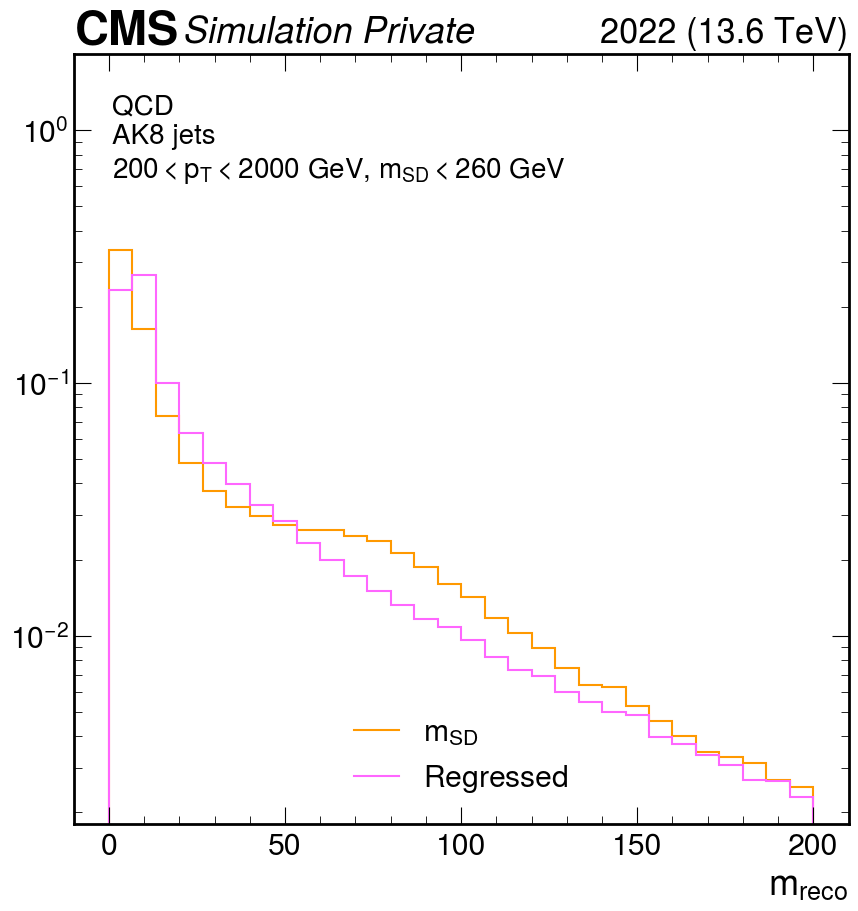

In [209]:
plt.style.use(mplhep.style.CMS)

fig, ax = plt.subplots(figsize=(10,10))

h = output["h"]

h1 = h.project("msd")[:]
n = h1.sum()
h1 = h1 / n
    
mplhep.histplot(h1, ax=ax, label=r"$m_{SD}$", color=colours["qcd"])

h1 = h.project("reg")[:]
n = h1.sum()
h1 = h1 / n
    
mplhep.histplot(h1, ax=ax, label=r"$Regressed$", color=colours["hbb"])
    
ax.set_yscale('log')
ax.set_xlabel(r"$m_{reco}$")
ax.legend(loc="lower center")
ax.set_ylim(0, 2)
              
label = mplhep.cms.label(ax=ax, data=False, year="2022", com=13.6, label="Private")

coffee = plt.text(0.05, 0.83, "QCD\nAK8 jets\n" + r"$200 < p_T < 2000$ GeV, $m_{SD} < 260$ GeV",
                  fontsize=20,
                  horizontalalignment='left',
                  verticalalignment='bottom',
                  transform=ax.transAxes,
                 )
              
# fig.savefig("Disc.pdf", bbox_inches='tight', pad_inches=0.1)